In [1]:
import os
import sys
import random
import math
import re
import time
import numpy as np


import matplotlib
import matplotlib.pyplot as plt

# Root directory of the project


ROOT_DIR = os.path.abspath("../..")

In [2]:
# Import Mask RCNN
sys.path.append(ROOT_DIR)
from mrcnn import utils
import mrcnn.model as modellib
from mrcnn import visualize
from mrcnn.model import log

from samples.face import face

%matplotlib inline

/home/jho/anaconda3/envs/mask/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:523: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/jho/anaconda3/envs/mask/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:524: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/jho/anaconda3/envs/mask/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:525: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/jho/anaconda3/envs/mask/lib/python3.6/site-packages/ten

In [3]:
# Directory to save logs and trained model
MODEL_DIR = os.path.join(ROOT_DIR, "logs")

# Local path to trained weights file
COCO_MODEL_PATH = os.path.join(ROOT_DIR, "mask_rcnn_coco.h5")

# Download COCO trained weights from Releases if needed
if not os.path.exists(COCO_MODEL_PATH):
    utils.download_trained_weights(COCO_MODEL_PATH)

## Notebook Preferences

In [4]:
def get_ax(rows=1, cols=1, size=8):
    """
    Return a Matplotlib Axes array to be used in
    all visualizations in the notebook. Provide a
    central point to control graph sizes.
    
    Change the default isze attribute to control the size
    of rendered images
    """
    
    _, ax = plt.subplots(rows, cols, figsize=(size*cols, size*rows))
    return ax


## Configurations

Configurations are defined in face.py

In [5]:
config = face.FaceConfig()
FACE_DIR = os.path.join(ROOT_DIR, "samples/face/face_data")

## Dataset

In [6]:
# Load dataset
# Get the dataset 'CelebA'

# dataset = face.FaceDataset()
# dataset.load_face(FACE_DIR, "train")

# Must call before using the dataset
# dataset.prepare()

# print("Image Count: {}".format(len(dataset.image_ids)))
# print("Class Count: {}".format(dataset.num_classes))
# for i, info in enumerate(dataset.class_info):
#     print("{:3}. {:50}".format(i, info['name']))

### Training dataset

In [7]:
# Training dataset
dataset_train = face.FaceDataset()
dataset_train.load_face(FACE_DIR, 'train')
dataset_train.prepare()

print("Image Count: {}".format(len(dataset_train.image_ids)))
print("Class Count: {}".format(dataset_train.num_classes))
for i, info in enumerate(dataset_train.class_info):
    print("{:3}. {:50}".format(i, info['name']))

Loading images: 100%|██████████| 3200/3200 [00:04<00:00, 716.00it/s]

Image Count: 3200
Class Count: 2
  0. BG                                                
  1. face                                              


### Validation Dataset

In [8]:
# Validation dataset
dataset_val = face.FaceDataset()
dataset_val.load_face(FACE_DIR, 'val')
dataset_val.prepare()

print("Image Count: {}".format(len(dataset_val.image_ids)))
print("Class Count: {}".format(dataset_val.num_classes))
for i, info in enumerate(dataset_val.class_info):
    print("{:3}. {:50}".format(i, info['name']))

Loading images: 100%|██████████| 355/355 [00:00<00:00, 729.51it/s]

Image Count: 355
Class Count: 2
  0. BG                                                
  1. face                                              


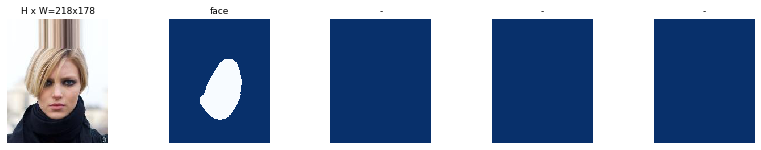

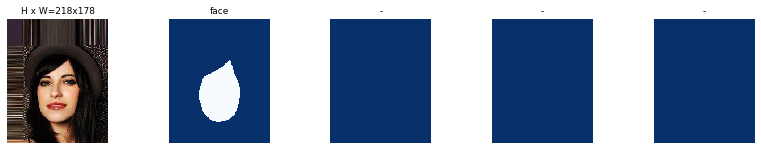

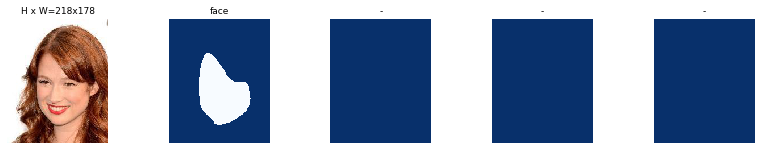

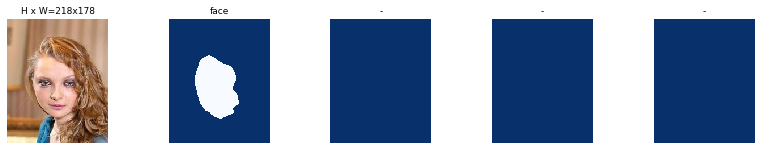

In [9]:
# Load and display random samples
image_ids = np.random.choice(dataset_train.image_ids, 4)
for image_id in image_ids:
    image = dataset_train.load_image(image_id)
    mask, class_ids = dataset_train.load_mask(image_id)
    visualize.display_top_masks(image, mask, class_ids, dataset_train.class_names)


## Create Model

In [10]:
# Create model in training mode
model = modellib.MaskRCNN(
        mode="training", 
        config=config,
        model_dir=MODEL_DIR)

Instructions for updating:
keep_dims is deprecated, use keepdims instead
Instructions for updating:
keep_dims is deprecated, use keepdims instead
Instructions for updating:
keep_dims is deprecated, use keepdims instead


In [11]:
# Which weights to start with?
init_weight = "coco" # imagenet, coco, or last

if init_weight == "imagenet":
    model.load_weights(model.get_imagenet_weights(), by_name=True)
elif init_weight == "coco":
    # Load weights trained on MS COCO, but skip layers that
    # are different due to the different number of classes
    # See README for instructions to download the COCO weights
    model.load_weights(COCO_MODEL_PATH, by_name=True,
                        exclude=["mrcnn_class_logits", "mrcnn_bbox_fc",
                                 "mrcnn_bbox", "mrcnn_mask"])
    
elif init_weight == "last":
    # Load the last model you trained and continue training
    model.load_weights(model.find_last(), by_name=True)



## Training

Train in two stages:

 1. Only the heads. Here we're freezing all the backbone layers and training only the randomly intialized layers
 (.e. the ones that we didn't use pre-trained weights from MS COCO).
 To train only the head layers, pass layers='heads' to the train() function.
 2. Fine-tune all layers. For this simple example it's not necessary, but we're including it to show the process.
 Simply pass layers="all to train all layers.
 

In [12]:
# Train the head branches
# Passing layers="heads" freezes all layers except the head
# layers. You can also pass a regular expression to select
# which layers to train by name pattern.
head_epochs = 10
model.train(dataset_train, dataset_val,
            learning_rate=config.LEARNING_RATE,
            epochs=head_epochs,
            layers='heads')




Starting at epoch 0. LR=0.001

Checkpoint Path: /home/jho/projects/Mask_RCNN/logs/face20200408T1803/mask_rcnn_face_{epoch:04d}.h5
Selecting layers to train
fpn_c5p5               (Conv2D)
fpn_c4p4               (Conv2D)
fpn_c3p3               (Conv2D)
fpn_c2p2               (Conv2D)
fpn_p5                 (Conv2D)
fpn_p2                 (Conv2D)
fpn_p3                 (Conv2D)
fpn_p4                 (Conv2D)
In model:  rpn_model
    rpn_conv_shared        (Conv2D)
    rpn_class_raw          (Conv2D)
    rpn_bbox_pred          (Conv2D)
mrcnn_mask_conv1       (TimeDistributed)
mrcnn_mask_bn1         (TimeDistributed)
mrcnn_mask_conv2       (TimeDistributed)
mrcnn_mask_bn2         (TimeDistributed)
mrcnn_class_conv1      (TimeDistributed)
mrcnn_class_bn1        (TimeDistributed)
mrcnn_mask_conv3       (TimeDistributed)
mrcnn_mask_bn3         (TimeDistributed)
mrcnn_class_conv2      (TimeDistributed)
mrcnn_class_bn2        (TimeDistributed)
mrcnn_mask_conv4       (TimeDistributed)
mrcnn_m

/home/jho/anaconda3/envs/mask/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:108: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/home/jho/anaconda3/envs/mask/lib/python3.6/site-packages/keras/engine/training.py:1987: UserWarning: Using a generator with `use_multiprocessing=True` and multiple workers may duplicate your data. Please consider using the`keras.utils.Sequence class.
  UserWarning('Using a generator with `use_multiprocessing=True`'


Epoch 1/10
 99/100 [============================>.] - ETA: 0s - loss: 1.1707 - rpn_class_loss: 0.0128 - rpn_bbox_loss: 0.3137 - mrcnn_class_loss: 0.0212 - mrcnn_bbox_loss: 0.4225 - mrcnn_mask_loss: 0.4004

/home/jho/anaconda3/envs/mask/lib/python3.6/site-packages/keras/engine/training.py:2142: UserWarning: Using a generator with `use_multiprocessing=True` and multiple workers may duplicate your data. Please consider using the`keras.utils.Sequence class.
  UserWarning('Using a generator with `use_multiprocessing=True`'


100/100 [==============================] - 47s - loss: 1.1626 - rpn_class_loss: 0.0127 - rpn_bbox_loss: 0.3110 - mrcnn_class_loss: 0.0210 - mrcnn_bbox_loss: 0.4198 - mrcnn_mask_loss: 0.3981 - val_loss: 0.6785 - val_rpn_class_loss: 0.0042 - val_rpn_bbox_loss: 0.1953 - val_mrcnn_class_loss: 0.0079 - val_mrcnn_bbox_loss: 0.2625 - val_mrcnn_mask_loss: 0.2085
Epoch 2/10
100/100 [==============================] - 27s - loss: 0.6151 - rpn_class_loss: 0.0069 - rpn_bbox_loss: 0.1814 - mrcnn_class_loss: 0.0064 - mrcnn_bbox_loss: 0.2166 - mrcnn_mask_loss: 0.2038 - val_loss: 0.6406 - val_rpn_class_loss: 0.0031 - val_rpn_bbox_loss: 0.1732 - val_mrcnn_class_loss: 0.0076 - val_mrcnn_bbox_loss: 0.2500 - val_mrcnn_mask_loss: 0.2066
Epoch 3/10
100/100 [==============================] - 27s - loss: 0.6104 - rpn_class_loss: 0.0094 - rpn_bbox_loss: 0.2152 - mrcnn_class_loss: 0.0086 - mrcnn_bbox_loss: 0.1899 - mrcnn_mask_loss: 0.1873 - val_loss: 0.5507 - val_rpn_class_loss: 0.0040 - val_rpn_bbox_loss: 0.182

In [13]:
# Fine tune all layers
# Passing layers="all" trains all layers. You can also 
# pass a regular expression to select which layers to
# train by name pattern.
all_epochs = 100
model.train(dataset_train, dataset_val, 
            learning_rate=config.LEARNING_RATE / 10,
            epochs=all_epochs,
            layers="all")


Starting at epoch 10. LR=0.0001

Checkpoint Path: /home/jho/projects/Mask_RCNN/logs/face20200408T1803/mask_rcnn_face_{epoch:04d}.h5
Selecting layers to train
conv1                  (Conv2D)
bn_conv1               (BatchNorm)
res2a_branch2a         (Conv2D)
bn2a_branch2a          (BatchNorm)
res2a_branch2b         (Conv2D)
bn2a_branch2b          (BatchNorm)
res2a_branch2c         (Conv2D)
res2a_branch1          (Conv2D)
bn2a_branch2c          (BatchNorm)
bn2a_branch1           (BatchNorm)
res2b_branch2a         (Conv2D)
bn2b_branch2a          (BatchNorm)
res2b_branch2b         (Conv2D)
bn2b_branch2b          (BatchNorm)
res2b_branch2c         (Conv2D)
bn2b_branch2c          (BatchNorm)
res2c_branch2a         (Conv2D)
bn2c_branch2a          (BatchNorm)
res2c_branch2b         (Conv2D)
bn2c_branch2b          (BatchNorm)
res2c_branch2c         (Conv2D)
bn2c_branch2c          (BatchNorm)
res3a_branch2a         (Conv2D)
bn3a_branch2a          (BatchNorm)
res3a_branch2b         (Conv2D)
bn3a_

100/100 [==============================] - 46s - loss: 0.3401 - rpn_class_loss: 0.0028 - rpn_bbox_loss: 0.1635 - mrcnn_class_loss: 0.0041 - mrcnn_bbox_loss: 0.0726 - mrcnn_mask_loss: 0.0971 - val_loss: 0.6745 - val_rpn_class_loss: 0.0030 - val_rpn_bbox_loss: 0.2662 - val_mrcnn_class_loss: 0.0134 - val_mrcnn_bbox_loss: 0.2751 - val_mrcnn_mask_loss: 0.1168
Epoch 12/100
100/100 [==============================] - 28s - loss: 0.4343 - rpn_class_loss: 0.0068 - rpn_bbox_loss: 0.2201 - mrcnn_class_loss: 0.0056 - mrcnn_bbox_loss: 0.0951 - mrcnn_mask_loss: 0.1067 - val_loss: 0.4954 - val_rpn_class_loss: 0.0043 - val_rpn_bbox_loss: 0.1874 - val_mrcnn_class_loss: 0.0095 - val_mrcnn_bbox_loss: 0.1846 - val_mrcnn_mask_loss: 0.1096
Epoch 13/100
100/100 [==============================] - 28s - loss: 0.5607 - rpn_class_loss: 0.0088 - rpn_bbox_loss: 0.3726 - mrcnn_class_loss: 0.0066 - mrcnn_bbox_loss: 0.0736 - mrcnn_mask_loss: 0.0990 - val_loss: 0.5271 - val_rpn_class_loss: 0.0016 - val_rpn_bbox_loss: 0

100/100 [==============================] - 28s - loss: 0.1910 - rpn_class_loss: 6.9616e-04 - rpn_bbox_loss: 0.0532 - mrcnn_class_loss: 0.0038 - mrcnn_bbox_loss: 0.0466 - mrcnn_mask_loss: 0.0867 - val_loss: 0.4517 - val_rpn_class_loss: 0.0052 - val_rpn_bbox_loss: 0.1695 - val_mrcnn_class_loss: 0.0144 - val_mrcnn_bbox_loss: 0.1735 - val_mrcnn_mask_loss: 0.0891
Epoch 34/100
100/100 [==============================] - 28s - loss: 0.1822 - rpn_class_loss: 6.0758e-04 - rpn_bbox_loss: 0.0480 - mrcnn_class_loss: 0.0023 - mrcnn_bbox_loss: 0.0411 - mrcnn_mask_loss: 0.0902 - val_loss: 0.3882 - val_rpn_class_loss: 6.0246e-04 - val_rpn_bbox_loss: 0.1467 - val_mrcnn_class_loss: 0.0110 - val_mrcnn_bbox_loss: 0.1448 - val_mrcnn_mask_loss: 0.0851
Epoch 35/100
100/100 [==============================] - 28s - loss: 0.2078 - rpn_class_loss: 0.0020 - rpn_bbox_loss: 0.0686 - mrcnn_class_loss: 0.0039 - mrcnn_bbox_loss: 0.0470 - mrcnn_mask_loss: 0.0864 - val_loss: 0.4058 - val_rpn_class_loss: 5.6810e-04 - val_

100/100 [==============================] - 28s - loss: 0.2463 - rpn_class_loss: 0.0031 - rpn_bbox_loss: 0.0801 - mrcnn_class_loss: 0.0061 - mrcnn_bbox_loss: 0.0666 - mrcnn_mask_loss: 0.0903 - val_loss: 0.4562 - val_rpn_class_loss: 0.0070 - val_rpn_bbox_loss: 0.1566 - val_mrcnn_class_loss: 0.0189 - val_mrcnn_bbox_loss: 0.1761 - val_mrcnn_mask_loss: 0.0976
Epoch 55/100
100/100 [==============================] - 28s - loss: 0.1917 - rpn_class_loss: 8.2628e-04 - rpn_bbox_loss: 0.0515 - mrcnn_class_loss: 0.0040 - mrcnn_bbox_loss: 0.0465 - mrcnn_mask_loss: 0.0888 - val_loss: 0.3774 - val_rpn_class_loss: 5.4413e-04 - val_rpn_bbox_loss: 0.1455 - val_mrcnn_class_loss: 0.0113 - val_mrcnn_bbox_loss: 0.1424 - val_mrcnn_mask_loss: 0.0777
Epoch 56/100
100/100 [==============================] - 28s - loss: 0.1977 - rpn_class_loss: 0.0015 - rpn_bbox_loss: 0.0652 - mrcnn_class_loss: 0.0040 - mrcnn_bbox_loss: 0.0464 - mrcnn_mask_loss: 0.0807 - val_loss: 0.3517 - val_rpn_class_loss: 0.0025 - val_rpn_bbox

100/100 [==============================] - 28s - loss: 0.1530 - rpn_class_loss: 5.6697e-04 - rpn_bbox_loss: 0.0352 - mrcnn_class_loss: 0.0027 - mrcnn_bbox_loss: 0.0284 - mrcnn_mask_loss: 0.0861 - val_loss: 0.3513 - val_rpn_class_loss: 0.0011 - val_rpn_bbox_loss: 0.1196 - val_mrcnn_class_loss: 0.0134 - val_mrcnn_bbox_loss: 0.1321 - val_mrcnn_mask_loss: 0.0851
Epoch 76/100
100/100 [==============================] - 28s - loss: 0.1663 - rpn_class_loss: 7.9816e-04 - rpn_bbox_loss: 0.0395 - mrcnn_class_loss: 0.0072 - mrcnn_bbox_loss: 0.0404 - mrcnn_mask_loss: 0.0784 - val_loss: 0.4791 - val_rpn_class_loss: 4.2302e-04 - val_rpn_bbox_loss: 0.1832 - val_mrcnn_class_loss: 0.0164 - val_mrcnn_bbox_loss: 0.2016 - val_mrcnn_mask_loss: 0.0775
Epoch 77/100
100/100 [==============================] - 28s - loss: 0.2250 - rpn_class_loss: 0.0053 - rpn_bbox_loss: 0.0770 - mrcnn_class_loss: 0.0058 - mrcnn_bbox_loss: 0.0453 - mrcnn_mask_loss: 0.0916 - val_loss: 0.3761 - val_rpn_class_loss: 0.0029 - val_rpn_

100/100 [==============================] - 27s - loss: 0.1542 - rpn_class_loss: 3.1157e-04 - rpn_bbox_loss: 0.0331 - mrcnn_class_loss: 0.0038 - mrcnn_bbox_loss: 0.0370 - mrcnn_mask_loss: 0.0801 - val_loss: 0.4123 - val_rpn_class_loss: 8.4708e-04 - val_rpn_bbox_loss: 0.1597 - val_mrcnn_class_loss: 0.0150 - val_mrcnn_bbox_loss: 0.1607 - val_mrcnn_mask_loss: 0.0760
Epoch 97/100
100/100 [==============================] - 27s - loss: 0.1593 - rpn_class_loss: 0.0028 - rpn_bbox_loss: 0.0450 - mrcnn_class_loss: 0.0044 - mrcnn_bbox_loss: 0.0329 - mrcnn_mask_loss: 0.0742 - val_loss: 0.3853 - val_rpn_class_loss: 0.0045 - val_rpn_bbox_loss: 0.1425 - val_mrcnn_class_loss: 0.0162 - val_mrcnn_bbox_loss: 0.1417 - val_mrcnn_mask_loss: 0.0804
Epoch 98/100
100/100 [==============================] - 27s - loss: 0.1699 - rpn_class_loss: 7.1369e-04 - rpn_bbox_loss: 0.0384 - mrcnn_class_loss: 0.0048 - mrcnn_bbox_loss: 0.0397 - mrcnn_mask_loss: 0.0863 - val_loss: 0.4306 - val_rpn_class_loss: 8.2278e-04 - val_

In [14]:
# Save weights
# Typically not needed because callbacks save after every epoch
# Uncomment to save manually
# model_path = os.path.join(MODEL_DIR, "mask_rcnn_shapes.200324.h5")
# model.keras_model.save_weights(model_path)

FACE_MODEL_DIR = os.path.join(MODEL_DIR, 'face')

import pathlib
pathlib.Path(FACE_MODEL_DIR).mkdir(exist_ok=True)

model_path = os.path.join(FACE_MODEL_DIR, 'face_epochs{}({}).h5'.format(all_epochs, head_epochs))
model.keras_model.save_weights(model_path)

